In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import uproot
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rc, rcParams

In [167]:
#file = uproot.open("mu5e100k.root")
file = uproot.open("mu5e10k.root")

In [168]:
tree = file["mu3e"]
hit_trajs = tree.arrays(["Ntrajectories", "traj_type", "traj_ID", "traj_vx", "traj_vy", "traj_vz"])
hits = tree.arrays(["Nhit", "hit_pixelid", "hit_mc_i"])
mchits = file["mu3e_mchits"]
hit_tid = mchits.arrays(["hid", "tid"])

In [169]:
class sensor():
    def __init__(self, id):
        self.station = (id >> 12) & 0x7
        self.layer = (id >> 10) & 0x3

class pixel_hit():
    def __init__(self, id):
        self.col = (id >> 8) & 0xFF
        self.row = (id >> 0) & 0xFF
        self.id = id
        self.sensor = sensor((id >> 16) & 0xFFFF)

def is_short_track(g):
    return g[0] >= 1 and g[1] >= 1 and g[4] >= 1 and g[5] >= 1

def is_long_track(g):
    return g[0] >= 1 and g[1] >= 1 and g[2] >= 1 and g[3] >= 1

In [170]:
goodframes = 0
goodidframes = 0
acceptanceframes = {
    "long": 0,
    "1short": 0,
    "2short": 0,
    "3short": 0,
    "4short": 0,
    "5short": 0,
    "total": 0
}
recurlacceptanceframes = 0
morethanonesignal = 0
n_frames = len(hits)
short_tracks = []
long_tracks = []
for hit_dict, traj_dict in zip(hits, hit_trajs):
    newid = True
    tracks_from_mu5e_decay = []
    for traji_type, vx, vy, vz, id in zip(traj_dict["traj_type"], traj_dict["traj_vx"], traj_dict["traj_vy"], traj_dict["traj_vz"], traj_dict["traj_ID"]):
        if traji_type != 171 and traji_type != 172: continue
        if np.abs(vz) > 50: continue
        vr = np.sqrt(vx * vx + vy * vy)
        if vr > 19: continue
        goodtrack = True
        if id in tracks_from_mu5e_decay: continue
        tracks_from_mu5e_decay.append(id)
    if goodtrack and len(tracks_from_mu5e_decay) > 0: goodframes += 1
    if len(tracks_from_mu5e_decay) > 5: morethanonesignal += 1
    if len(tracks_from_mu5e_decay) != 5: continue
    goodidframes += 1
    track_dict = {
    # track |l0|l1|l2|l3|r0|r1|r2|r3   
        0 : [0, 0, 0, 0, 0, 0, 0, 0],
        1 : [0, 0, 0, 0, 0, 0, 0, 0],
        2 : [0, 0, 0, 0, 0, 0, 0, 0],
        3 : [0, 0, 0, 0, 0, 0, 0, 0],
        4 : [0, 0, 0, 0, 0, 0, 0, 0]
    }
    short_track = 0
    long_track = 0
    for pixelID, mc_i in zip(hit_dict["hit_pixelid"], hit_dict["hit_mc_i"]):
        hit = pixel_hit(pixelID)

        for k in track_dict:
            # we only check for decays in the central detector
            if hit_tid[mc_i]["tid"] == tracks_from_mu5e_decay[k]and hit.sensor.station == 0:
                # check for ingoing (recurlers) in all four layers
                if hit_tid[mc_i]["hid"] < 0:
                    track_dict[k][hit.sensor.layer+4] += 1
                # check outgoing (long) tracks in central station
                if hit_tid[mc_i]["hid"] > 0 :
                    track_dict[k][hit.sensor.layer] += 1

    # check for track combination
    for k in track_dict:
        if is_long_track(track_dict[k]): long_track += 1
        if is_short_track(track_dict[k]): short_track += 1
    short_tracks.append(short_track)
    long_tracks.append(long_track)

    if long_track == 5: acceptanceframes["long"] += 1
    if short_track == 1: acceptanceframes["1short"] += 1
    if short_track == 2: acceptanceframes["2short"] += 1
    if short_track == 3: acceptanceframes["3short"] += 1
    if short_track == 4: acceptanceframes["4short"] += 1
    if short_track == 5: acceptanceframes["5short"] += 1
    acceptanceframes["total"] += 1

    if  g1[6] >= 1 and g1[7] >= 1 and \
        g2[6] >= 1 and g2[7] >= 1 and \
        g3[6] >= 1 and g3[7] >= 1 and \
        g4[6] >= 1 and g4[7] >= 1 and \
        g5[6] >= 1 and g5[7] >= 1:
        recurlacceptanceframes += 1


In [172]:
print(goodframes, "good frames out of", n_frames)
print(goodidframes, "good ID frames (5 tracks from mu to 5e) out of", n_frames)
print(morethanonesignal, "frames with more than one mu5e event")

6618 good frames out of 10000
4746 good ID frames (5 tracks from mu to 5e) out of 10000
0 frames with more than one mu5e event


In [173]:
class decay():
    def __init__(self, weights):
        self.weights = weights

def get_histogram_and_errors(
    var, decay, bins, color, ax=None, rescale_w=1, mask=None, errorbar=True, **kwargs
):
    if mask is not None:
        values = var[mask]
        weights = decay.weights[mask] * rescale_w
    else:
        values = var
        weights = decay.weights * rescale_w

    pred, bin_edges = np.histogram(values, bins=bins, weights=weights)

    # If performed selection, error on the efficiency needs to be propagated
    if mask is None:
        pred_err2 = np.histogram(values, bins=bins, weights=weights**2)[0]
    else:
        S, _ = np.histogram(var[mask], bins=bins, weights=decay.weights[mask])
        N, _ = np.histogram(var, bins=bins, weights=decay.weights)

        S_pred_err2 = np.histogram(
            var[mask], bins=bins, weights=(decay.weights[mask] * rescale_w) ** 2
        )[0]
        N_pred_err2 = np.histogram(
            var, bins=bins, weights=(decay.weights * rescale_w) ** 2
        )[0]

        eps = S / N
        eps_pred_err2 = N_pred_err2 * (S / N**2) ** 2 + S_pred_err2 * (1 / N**2)
        pred_err2 = eps_pred_err2 * N**2 + N_pred_err2 * (eps) ** 2

    pred_err = np.sqrt(pred_err2)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    if ax is not None:
        ax.hist(bin_centers, weights=pred, bins=bin_edges, edgecolor=color, **kwargs)
        #  label=f'kde prediction: {pred.sum():.2g} '\
        # f'$\pm$ {100*np.sqrt(pred_err2.sum())/pred.sum():.2g}%')

        if errorbar:
            for edge_left, edge_right, pred, err in zip(
                bin_edges[:-1], bin_edges[1:], pred, pred_err
            ):
                width = edge_right - edge_left
                if "rwidth" in kwargs.keys():
                    edge_left = (edge_right + edge_left) / 2 - kwargs["rwidth"] / 2
                    edge_right = (edge_right + edge_left) / 2 + kwargs["rwidth"] / 2
                    width = kwargs["rwidth"]

                ax.add_patch(
                    patches.Rectangle(
                        (edge_left, pred - err),
                        width,
                        2 * err,
                        hatch="\\\\\\\\\\\\\\\\",
                        fill=False,
                        linewidth=0,
                        color=color,
                        alpha=0.6,
                        rasterized=True,
                    )
                )

    return pred, pred_err, bin_edges

fsize = 12
fsize_annotate = 10

std_figsize = (1.2 * 3.7, 1.6 * 2.3617)
std_axes_form = [0.16, 0.15, 0.81, 0.76]

electron_color = (0.85, 0.39, 0.14)
positron_color = (0.16, 0.37, 0.65)
# ax_colors = "#CFCFCF"
ax_colors = "darkgrey"
text_color = "grey"

def std_fig(ax_form=std_axes_form, figsize=std_figsize, rasterized=False):
    rcparams = {
        "axes.labelsize": fsize,
        "xtick.labelsize": fsize,
        "ytick.labelsize": fsize,
        "figure.figsize": std_figsize,
        "legend.frameon": False,
        "legend.loc": "best",
    }
    plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"
    rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
    rc("text", usetex=True)
    rcParams.update(rcparams)
    mpl.rcParams["hatch.linewidth"] = 0.25
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes(ax_form, rasterized=rasterized)
    ax.patch.set_alpha(0.0)

    return fig, ax

In [174]:
def plot_tracks(short_tracks, long_tracks):
    fig, ax = std_fig()
    BINS = np.linspace(0, 7, 8, endpoint=True)
    WIDTH = 0.6
    HITS = 6  # for long track
    LW = 1.3
    
    weights_short = np.array([1 for i in short_tracks])
    short_tracks = np.array(short_tracks)
    weights_long = np.array([1 for i in long_tracks])
    long_tracks = np.array(long_tracks)
    
    kwargs = {
        "lw": 0.0,
        "histtype": "barstacked",
        "rwidth": WIDTH,
        "alpha": 0.3,
        "facecolor": "deeppink",
    }
    kwargs["label"] = r"$3e^+ \, 2e^-$ (short)"
    _ = get_histogram_and_errors(
        short_tracks,
        decay(weights_short),
        ax=ax,
        bins=BINS,
        color="deeppink",
        errorbar=True,
        **kwargs
    )
    
    kwargs = {"lw": 1.25, "histtype": "barstacked", "rwidth": WIDTH, "facecolor": "None"}
    kwargs["label"] = r"$3e^+ \, 2e^-$ (long)"
    _ = get_histogram_and_errors(
        long_tracks,
        decay(weights_long),
        ax=ax,
        bins=BINS,
        color="steelblue",
        errorbar=True,
        **kwargs
    )
    
    #ax.set_ylabel(r"differential $\mathcal{B}$", fontsize=12)
    ax.set_ylabel(r"\#", fontsize=12)
    ax.set_yscale("log")
    #ax.set_ylim(0.1e-16, 5e-10)
    #ax.set_yticks(np.geomspace(1e-17, 1e-10, 8, endpoint=True))
    
    ax.set_xlabel(r"Number of tracks", fontsize=12)
    ax.set_xticks(BINS + 0.5)
    ax.set_xticklabels([int(b) for b in BINS])
    ax.set_xlim(2.0, 6)
    
    ax.grid(alpha=1, lw=0.25, zorder=-10, color="grey")
    
    leg1 = ax.legend(
        frameon=False,
        fontsize=10,
        ncol=1,
        handlelength=1,
        columnspacing=2,
        markerfirst=True,
        loc="upper right",
    )
    (l1,) = ax.plot([], [], lw=LW, ls=(1, (4, 0)), color="k")
    (l2,) = ax.plot([], [], lw=LW, ls=(1, (3, 1)), color="k")
    (l3,) = ax.plot([], [], lw=LW, ls=(1, (1, 0.5)), color="k")
    leg2 = plt.legend(
        [l1, l2, l3],
        [
            #r"All",
            #r"$(N^{e^-}_{\rm long} = 2)$",
            #r"$(N^{e^-}_{\rm long} = 2)$ \& ($E_{\rm miss} < 10$ MeV)",
        ],
        loc="upper right",
        frameon=False,
        fontsize=9,
        ncol=1,
        handlelength=1.5,
        columnspacing=2,
        markerfirst=True,
    )
    ax.add_artist(leg1)

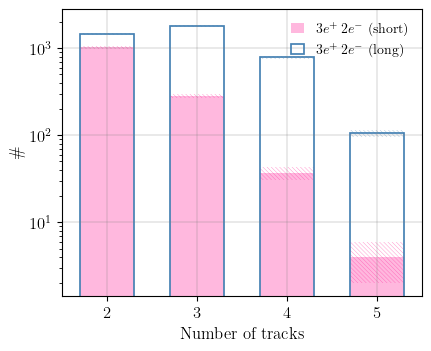

In [175]:
plot_tracks(short_tracks, long_tracks)

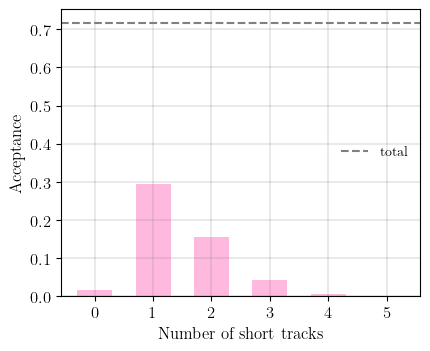

In [176]:
fig, ax = std_fig()
WIDTH = 0.6
HITS = 6  # for long track
LW = 1.3

acceptance = np.array([acceptanceframes[k] / goodframes for k in acceptanceframes])
plt.axhline(acceptance[-1], color="gray", linestyle="--", label="total")
acceptance = acceptance[:-1]
BINS = np.array([i for i in range(len(acceptance))])
x = np.array([i for i in range(len(acceptance))])

ax.bar(x, acceptance, facecolor="deeppink", alpha=0.3, lw=0.0, width=0.6)

#ax.set_ylabel(r"differential $\mathcal{B}$", fontsize=12)
ax.set_ylabel(r"Acceptance", fontsize=12)
#ax.set_ylim(0.1e-16, 5e-10)
#ax.set_yticks(np.geomspace(1e-17, 1e-10, 8, endpoint=True))

ax.set_xlabel(r"Number of short tracks", fontsize=12)
ax.set_xticks(BINS)
ax.set_xticklabels([round(b,0) for b in BINS])

ax.grid(alpha=1, lw=0.25, zorder=-10, color="grey")
plt.legend(loc="center right")
plt.show()